In [6]:
import numpy as np
import cv2
import open3d as o3d
import json
import math
import os
import random
import matplotlib.pyplot as plt

In [7]:
with open("../calib_data.json","r") as f:
    j = json.load(f)
j["cameraData"][0][1]
rgb_data=j["cameraData"][1][1]
left_data=j["cameraData"][2][1]
right_data=j["cameraData"][0][1]

In [8]:
bl = 73.10253143310547
rcx = right_data["intrinsicMatrix"][0][2]
rcy = right_data["intrinsicMatrix"][1][2]
rfx = right_data["intrinsicMatrix"][0][0]
rfy = right_data["intrinsicMatrix"][1][1]

rgb_cx=rgb_data["intrinsicMatrix"][0][2]
rgb_cy=rgb_data["intrinsicMatrix"][1][2]
rgb_fx=rgb_data["intrinsicMatrix"][0][0]
rgb_fy=rgb_data["intrinsicMatrix"][1][1]

In [14]:
frame = 0

color = cv2.imread("../images/"+str(frame).zfill(3)+"color.png")
rgb_frame = cv2.cvtColor(color ,cv2.COLOR_BGRA2RGB)
left_frame = cv2.imread("../images/"+str(frame).zfill(3)+"recLeft.png")
right_frame = cv2.imread("../images/"+str(frame).zfill(3)+"recRight.png")
dis = cv2.imread("../images/"+str(frame).zfill(3)+"disparity.png")
conf = cv2.imread("../images/"+str(frame).zfill(3)+"conf.png")

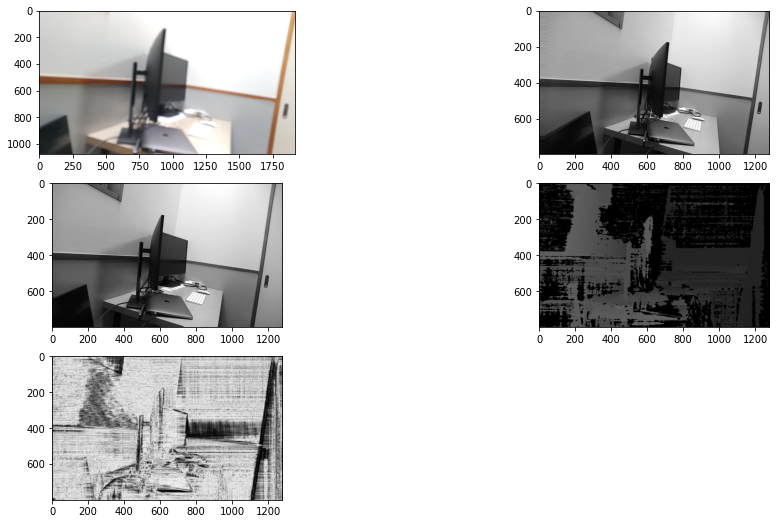

In [15]:
plt.figure(figsize=(16,9))
plt.subplot(321).imshow(rgb_frame)
plt.subplot(322).imshow(left_frame,vmin=0, vmax=255)
plt.subplot(323).imshow(right_frame,vmin=0, vmax=255)
plt.subplot(324).imshow(dis)
plt.subplot(325).imshow(conf)

1252 matches found


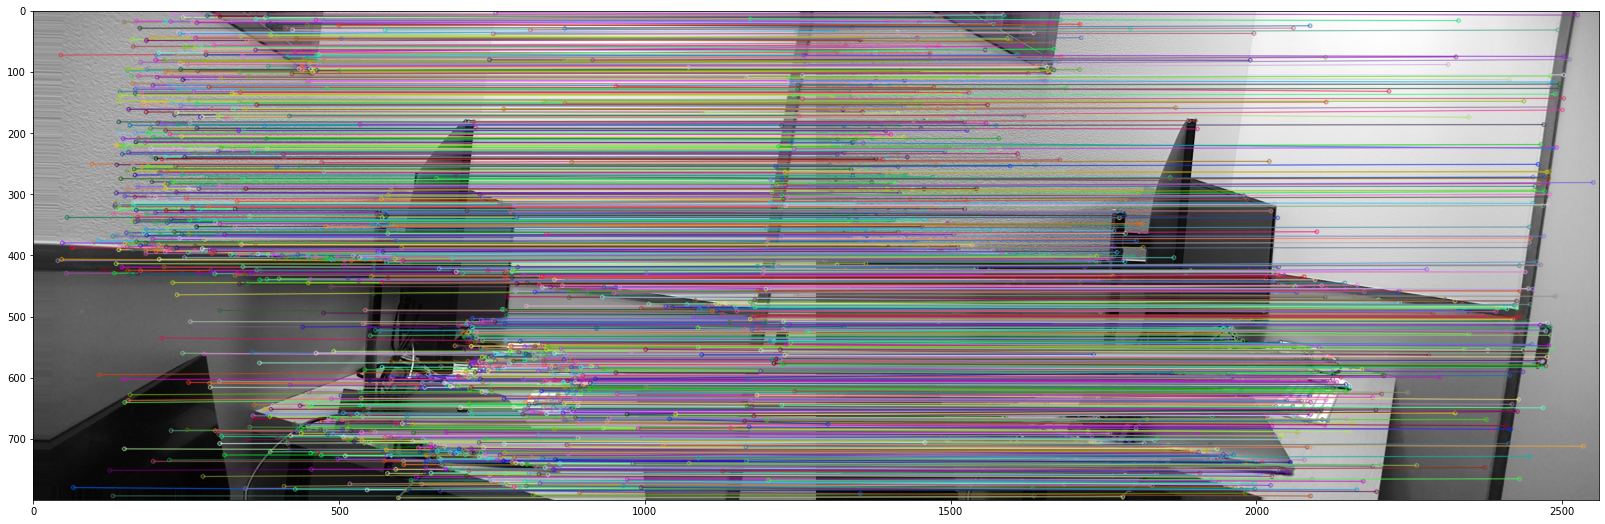

In [20]:
def feature_compute(left_frame,right_frame,feature_detection="SIFT",display=False):
    if feature_detection == "SIFT":
#         feature=cv2.SIFT_create(nOctaveLayers=20,contrastThreshold=0.001,edgeThreshold =100)
        feature=cv2.SIFT_create(contrastThreshold=0.001,edgeThreshold =100)
    elif feature_detection == "AKAZE":
        feature=cv2.AKAZE_create(threshold=0.00000001)
#         feature=cv2.AKAZE_create(t) 
    elif feature_detection == "ORB":
         feature=cv2.ORB_create()
    feature_left_kp, feature_left_des = feature.detectAndCompute(left_frame, None)
    feature_right_kp, feature_right_des = feature.detectAndCompute(right_frame, None)
    feature_bf = cv2.BFMatcher(crossCheck=True)
    feature_matches = feature_bf.match(feature_left_des, feature_right_des)

    feature_matches = [i for i in feature_matches if abs(feature_left_kp[i.queryIdx].pt[1]-feature_right_kp[i.trainIdx].pt[1])<10]
    print(len(feature_matches),"matches found")
    
    if display:
        img_feature = cv2.drawMatches(left_frame, feature_left_kp, right_frame , feature_right_kp, feature_matches, None, flags=2)
        plt.figure(figsize=(32,9))
        plt.imshow(img_feature)
        plt.show()
    return feature_left_kp, feature_left_des , feature_right_kp, feature_right_des , feature_matches
feature_left_kp, feature_left_des,feature_right_kp,feature_right_des,feature_matches=feature_compute(left_frame,right_frame,feature_detection="SIFT",display=True)

In [21]:
def feature_3d_position(feature_left_kp, feature_left_des,feature_right_kp, feature_right_des,feature_matches):
    positions = []
    right_descriptions = []
    right_kp = []
    for match in feature_matches:
        left_ind=match.queryIdx
        right_ind=match.trainIdx
        left_pt=feature_left_kp[left_ind].pt
        right_pt=feature_right_kp[right_ind].pt
        d = left_pt[0]-right_pt[0]
        if d < 1:
            pass
        else:
            z=rfx*bl/d
            x= (right_pt[0]-rcx)*bl/d
            y=(right_pt[1]-rcy)*bl/d
            position=[x,y,z]
            description =feature_right_des[right_ind]
            positions.append(position)
            right_descriptions.append(description)
            #! point!!
            right_kp.append(feature_right_kp[right_ind])
    positions = np.asarray(positions)
    right_descriptions=np.asarray(right_descriptions)
    right_kp=np.asarray(right_kp)
    return positions,right_descriptions,right_kp
positions,right_descriptions,right_kp=feature_3d_position(feature_left_kp, feature_left_des,feature_right_kp, feature_right_des,feature_matches)

array([[-2.24749606e+03, -1.16062020e+01,  3.20261336e+03],
       [-3.80805738e+03, -2.18246365e+03,  5.54874705e+03],
       [-1.81845718e+03,  6.49356278e+01,  2.63248878e+03],
       ...,
       [ 1.18053303e+03, -6.58800244e+02,  1.71004205e+03],
       [ 4.66288604e+00,  1.35429623e+01,  1.04943653e+02],
       [ 1.26666894e+03, -6.85491436e+02,  1.80691369e+03]])